In [1]:
import pickle
import numpy as np
import scvelo as scv
import scanpy
import torch

from veloproj import *
from eval_util import evaluate

scv.settings.verbosity = 1

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-5',
                               '--n-epochs', '10000', 
                               '--g-rep-dim', '50',
                               '--k-dim', '50',
                               '--data-dir', './retina.h5ad',
                               '--model-name', 'retina_model.cpt',
                               '--exp-name', 'CohAE_retina',
                               '--device', 'cuda:2',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', 'SU',
                               '--ld_nb_g_src', "SU",
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'false',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_tsne',
                               '--vis_type_col', 'Annotation',
                               '--scv_n_jobs', '10',
                               '--v_rg_wt', '0.01' # with low-dimensional velocity constraints, 
                                                   # 1) project a velocity matrix (e.g., by scvelo stochastic mode) 
                                                   # into low-dim space, which was described in
                                                   # our paper https://www.biorxiv.org/content/10.1101/2021.03.19.436127v1.full
                                                   # 2) using low-dim S and U to fit V in the low-dim space using steady-state model
                                                   # make loss to constrain the projected and newly estimated Vs to be similar
                                                   # we currently use smoothl1loss.
                                                   # This parameter weighs this constrain loss.
                              ])
args                              

Namespace(data_dir='./retina.h5ad', model_name='retina_model.cpt', exp_name='CohAE_retina', adata=None, mask_cluster_list=None, use_x=False, fit_offset_train=False, fit_offset_pred=False, use_offset_pred=False, is_half=False, gnn_layer='GAT', use_norm=False, sl1_beta=1.0, v_rg_wt=0.01, n_nb_newadata=30, scv_n_jobs=10, refit=True, output='./', vis_key='X_tsne', vis_type_col='Annotation', z_dim=100, n_conn_nb=30, g_rep_dim=50, h_dim=256, k_dim=50, conv_thred=1e-06, n_epochs=10000, lr=1e-05, weight_decay=0.0, seed=42, log_interval=100, device='cuda:2', gumbsoft_tau=5.0, aux_weight=1.0, nb_g_src='SU', ld_nb_g_src='SU', n_raw_gene=2000, lr_decay=0.9, ld_adata='projection.h5')

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [
    ("Progenitor", "Neuroblast"), 
    ("Neuroblast", "AC/HC"), 
    ("Neuroblast", "RGC"), 
    ("Neuroblast", "PR"), 
    ]
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
adata = scanpy.read_h5ad('/home/bio211u1/dat_transfer/retina.h5ad')
adata

AnnData object with n_obs × n_vars = 2726 × 31053
    obs: 'Clusters', 'Annotation'
    uns: 'Annotation_colors'
    obsm: 'X_umap'
    layers: 'spliced', 'unspliced'

In [6]:
scv.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

2024-05-02 20:22:25.809797: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 20:22:25.843923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 20:22:25.843952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 20:22:25.845212: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 20:22:25.851633: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 20:22:25.852200: I tensorflow/core/platform/cpu_feature_guard.cc:1

Abundance of ['spliced', 'unspliced']: [0.73 0.27]
AnnData object with n_obs × n_vars = 2726 × 2000
    obs: 'Clusters', 'Annotation', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'Annotation_colors', 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


In [7]:
scanpy.tl.tsne(adata)

In [8]:
#steady
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata, n_jobs=10)
scv.tl.velocity_confidence(adata)

  0%|          | 0/2726 [00:00<?, ?cells/s]

saving figure to file ./figures/scvelo_ss_tsne_retina.png


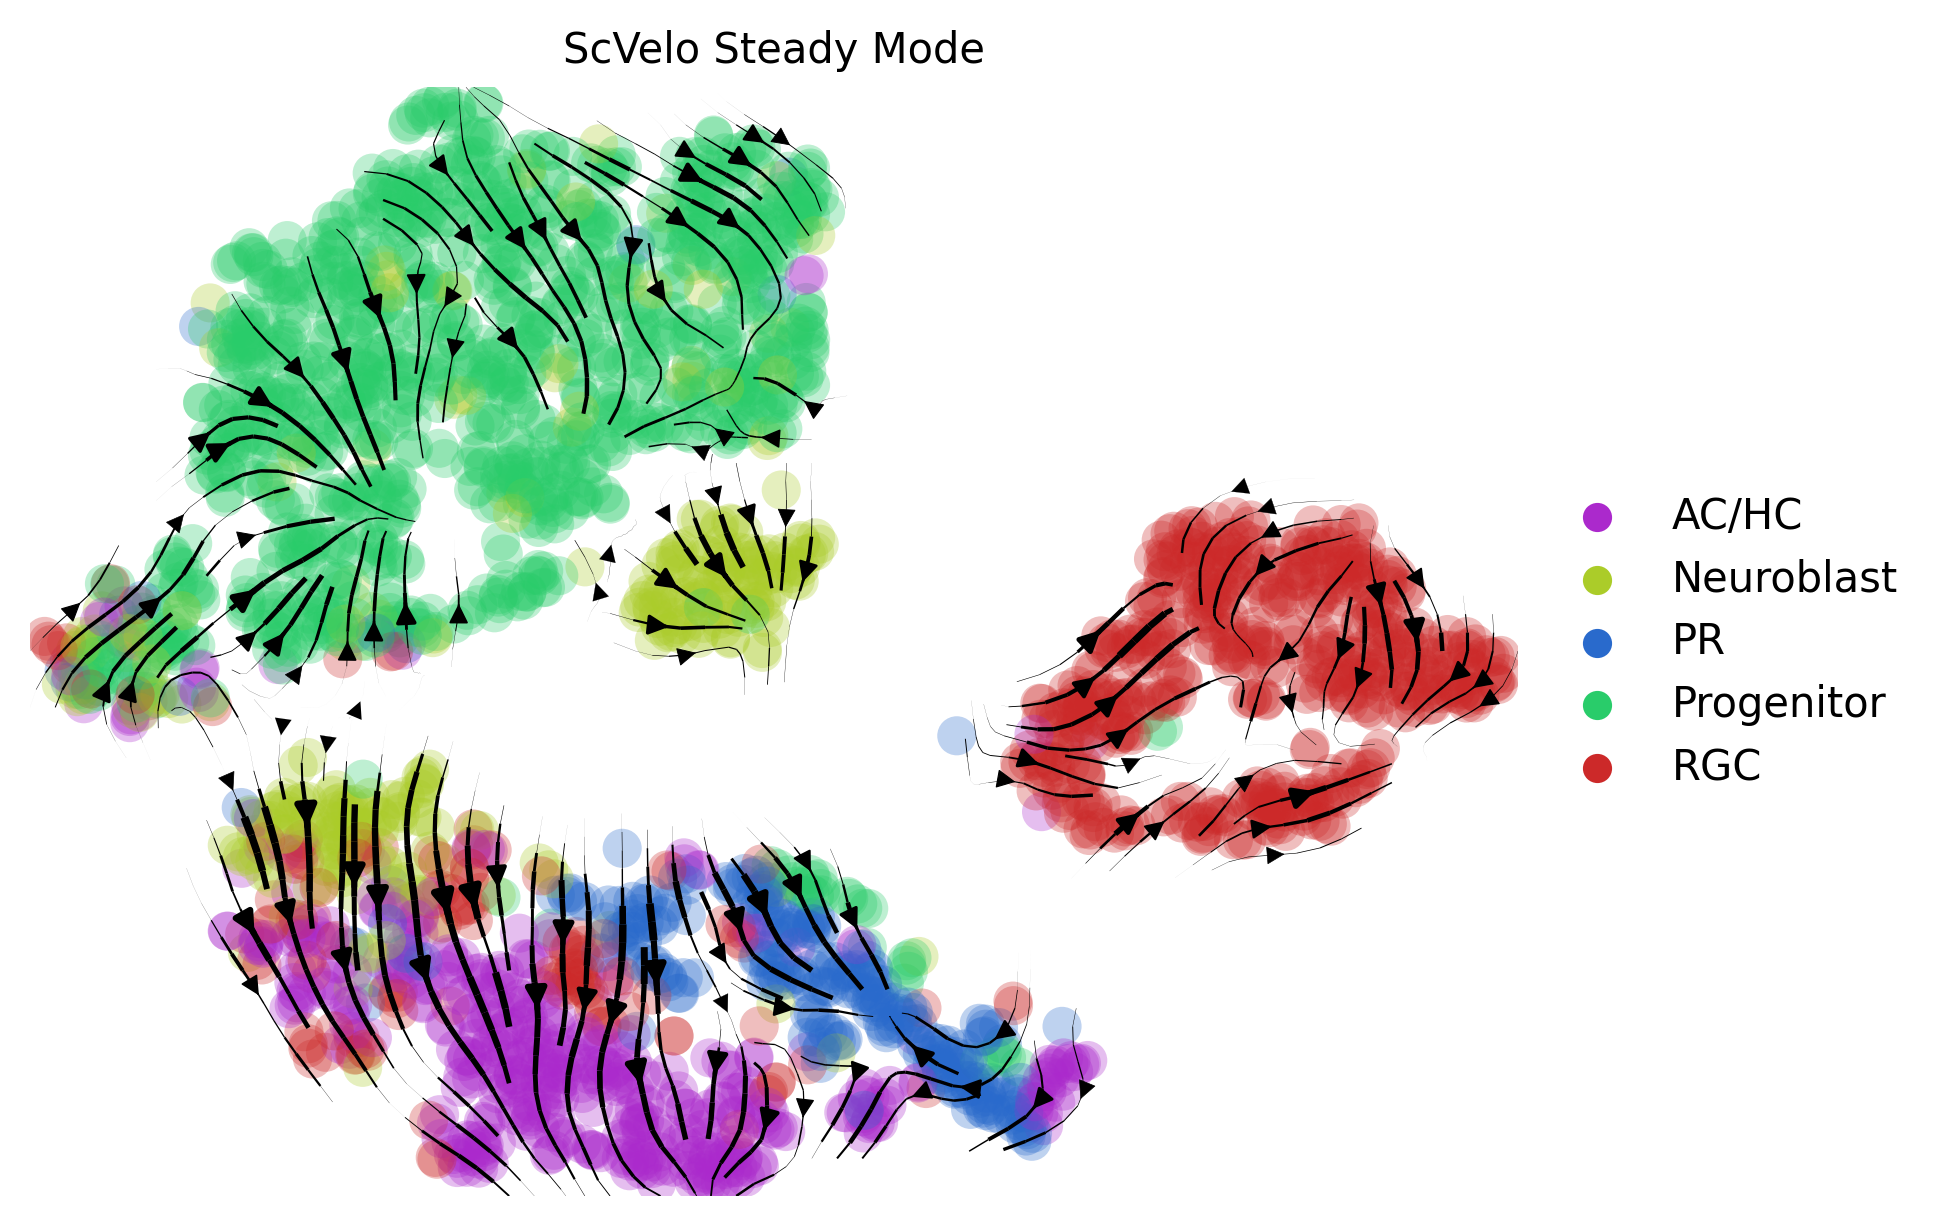

AnnData object with n_obs × n_vars = 2726 × 2000
    obs: 'Clusters', 'Annotation', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'Annotation_colors', 'pca', 'neighbors', 'tsne', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_umap', 'X_pca', 'X_tsne', 'velocity_tsne'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [9]:
#Project the velocities投射速度
scv.pl.velocity_embedding_stream(adata, legend_loc="right margin", basis=args.vis_key, color=args.vis_type_col,
                                 dpi=300, title='ScVelo Steady Mode',save='ss_tsne_retina.png'
                                )
adata

In [21]:
exp_metrics["steady_mode"] = evaluate(adata, cluster_edges, args.vis_type_col, "velocity", x_emb=args.vis_key)

# Cross-Boundary Transition Score (A->B)
{('Progenitor', 'Neuroblast'): 0.0454419, ('Neuroblast', 'AC/HC'): 0.151623, ('Neuroblast', 'RGC'): 0.15827669, ('Neuroblast', 'PR'): 0.10917357}
Total Mean: 0.11612878739833832
# Cross-Boundary Velocity Coherence (A->B)
{('Progenitor', 'Neuroblast'): 0.8713295, ('Neuroblast', 'AC/HC'): 0.8535699, ('Neuroblast', 'RGC'): 0.88444084, ('Neuroblast', 'PR'): 0.825017}
Total Mean: 0.8585892915725708
# Cross-Boundary Direction Correctness (A->B)
{('Progenitor', 'Neuroblast'): 0.009000120862952718, ('Neuroblast', 'AC/HC'): 0.30781171755806164, ('Neuroblast', 'RGC'): 0.3532447120854132, ('Neuroblast', 'PR'): 0.19953370312408766}
Total Mean: 0.2173975634076288
# In-cluster Coherence
{'AC/HC': 0.91660905, 'Neuroblast': 0.9200961, 'PR': 0.88599855, 'Progenitor': 0.9217777, 'RGC': 0.9340173}
Total Mean: 0.9156997799873352
# In-cluster Confidence
{'AC/HC': 0.9151738224499816, 'Neuroblast': 0.9272633762035555, 'PR': 0.8839460564958446, 'Progenitor': 0.95248718

Abundance of ['spliced', 'unspliced']: [0.73 0.27]


  0%|          | 0/747 [00:00<?, ?gene/s]

  0%|          | 0/2726 [00:00<?, ?cells/s]

saving figure to file ./figures/scvelo_dyn_umap_retina.png


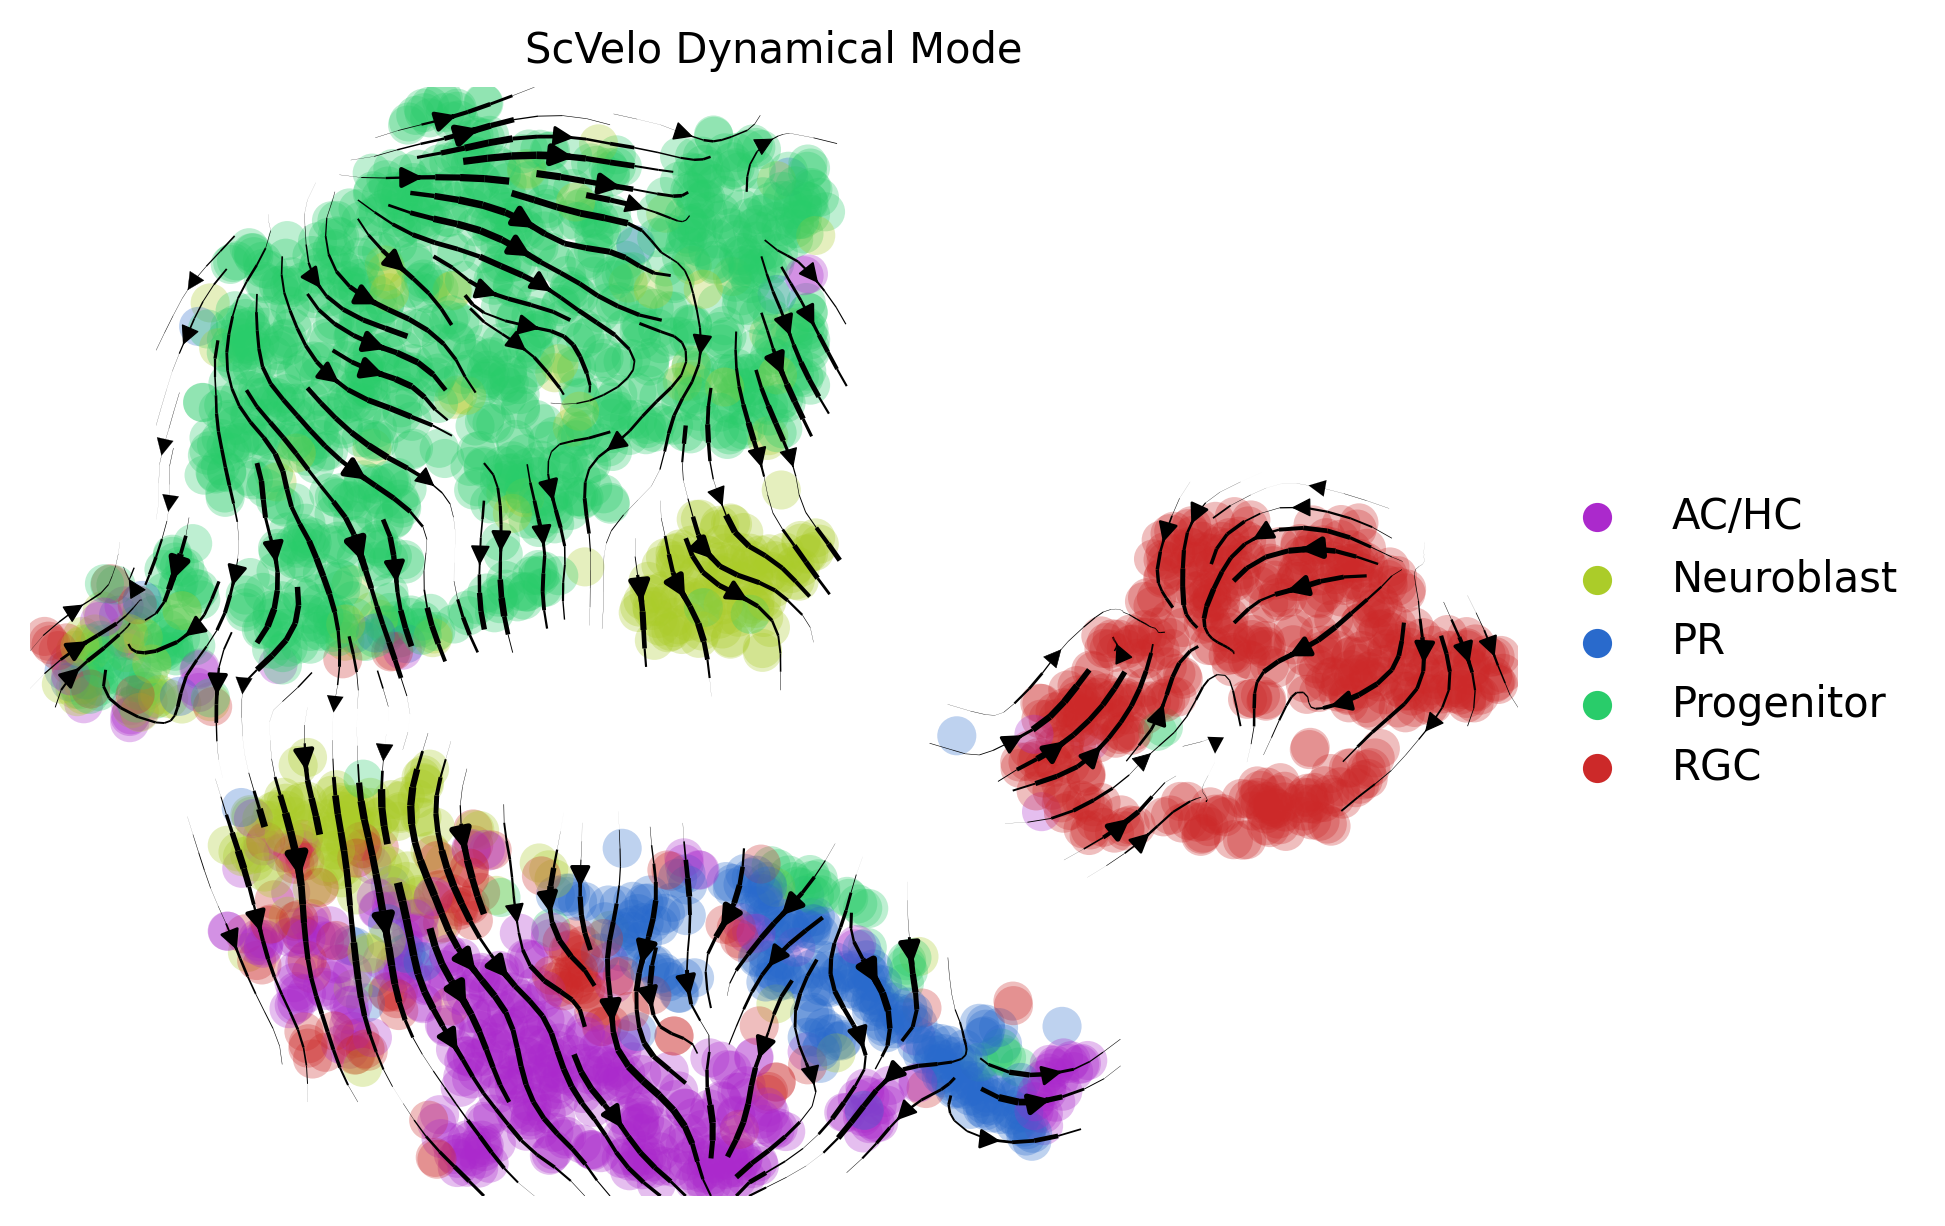

# Cross-Boundary Transition Score (A->B)
{('Progenitor', 'Neuroblast'): 0.1783242, ('Neuroblast', 'AC/HC'): 0.30733216, ('Neuroblast', 'RGC'): 0.336727, ('Neuroblast', 'PR'): 0.21310921}
Total Mean: 0.2588731348514557
# Cross-Boundary Velocity Coherence (A->B)
{('Progenitor', 'Neuroblast'): 0.7533648091404767, ('Neuroblast', 'AC/HC'): 0.8227833456444892, ('Neuroblast', 'RGC'): 0.8509561358375879, ('Neuroblast', 'PR'): 0.8036549847580167}
Total Mean: 0.8076898188451426
# Cross-Boundary Direction Correctness (A->B)
{('Progenitor', 'Neuroblast'): 0.2628770915655364, ('Neuroblast', 'AC/HC'): 0.4589610433039525, ('Neuroblast', 'RGC'): 0.41520148467298074, ('Neuroblast', 'PR'): 0.3357535082560055}
Total Mean: 0.3681982819496188
# In-cluster Coherence
{'AC/HC': 0.8902420628256907, 'Neuroblast': 0.844066241873689, 'PR': 0.8971273536226035, 'Progenitor': 0.8114602630315865, 'RGC': 0.866802053130332}
Total Mean: 0.8619395948967803
# In-cluster Confidence
{'AC/HC': 0.8741216187911197, 'Neuroblast

In [10]:
#dynamical
adata = scanpy.read_h5ad('/home/bio211u1/dat_transfer/retina.h5ad')

scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scanpy.tl.tsne(adata)

scv.tl.recover_dynamics(adata, n_jobs=args.scv_n_jobs)
scv.tl.velocity(adata, vkey='dyn_velocity', mode="dynamical")

scv.tl.velocity_graph(adata, vkey='dyn_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')

scv.pl.velocity_embedding_stream(adata,  
                                legend_loc="right margin", 
                                vkey="dyn_velocity", 
                                basis=args.vis_key, 
                                color=[args.vis_type_col],
                                dpi=300, 
                                title='ScVelo Dynamical Mode',
                                save='dyn_umap_retina.png')
exp_metrics["dyn_mode"] = evaluate(adata[:, adata.var.dyn_velocity_genes], cluster_edges, args.vis_type_col, "dyn_velocity", x_emb=args.vis_key)
